In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

dirname = os.getcwd()
csv_path = os.path.join(dirname, 'stock_data.csv')
print(csv_path)

/home/ql2004/projects/StockNN_to_SpringAPI/stock_data.csv


## Data Preprocessing

### Data Cleaning

In [8]:
#getting data for stocks
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]
data = yf.download(stocks, start="2018-01-01", end="2024-01-01", interval="1d")


[*********************100%***********************]  5 of 5 completed


In [9]:
print("Data Preview:")
print(data.head())

Data Preview:
Price                      Adj Close                                   \
Ticker                          AAPL       AMZN      GOOGL       MSFT   
Date                                                                    
2018-01-02 00:00:00+00:00  40.524353  59.450500  53.527958  79.792931   
2018-01-03 00:00:00+00:00  40.517296  60.209999  54.441196  80.164261   
2018-01-04 00:00:00+00:00  40.705494  60.479500  54.652668  80.869812   
2018-01-05 00:00:00+00:00  41.168930  61.457001  55.377377  81.872467   
2018-01-08 00:00:00+00:00  41.016022  62.343498  55.572891  81.956009   

Price                                    Close                        \
Ticker                         NVDA       AAPL       AMZN      GOOGL   
Date                                                                   
2018-01-02 00:00:00+00:00  4.930220  43.064999  59.450500  53.660500   
2018-01-03 00:00:00+00:00  5.254698  43.057499  60.209999  54.576000   
2018-01-04 00:00:00+00:00  5.282397  43.2

In [10]:
#data cleaning to ensure there are no:
# missing values from holidays/weekends
# Ensure all dates are in UTC
# remove duplicates

# Summary statistics for each column
print("Summary Statistics:")
print(data.describe())

#Use mean and median tto guage the quality of data or if its skewed. (if mean is significantly higher or lower than the median)
#Higher standard deviation means higher volatility
#Use percentiles to show what typical vs extreme prices look like over time

# check for missing values
missing_data = data.isnull().sum()
print("\nMissing vals")
print(missing_data[missing_data > 0]) #print the data in columns only if its greater than 1
#there are no missing values (skip this part Jake)

Summary Statistics:
Price     Adj Close                                                      \
Ticker         AAPL         AMZN        GOOGL         MSFT         NVDA   
count   1509.000000  1509.000000  1509.000000  1509.000000  1509.000000   
mean     108.312071   120.070903    90.966566   207.914877    15.729655   
std       51.164457    33.408177    31.271053    83.786302    12.231726   
min       33.952545    59.450500    49.111893    78.920250     3.151646   
25%       51.469154    90.698997    60.072254   128.783829     5.964214   
50%      121.009552   114.302002    87.802582   215.288071    13.119003   
75%      150.900192   154.474503   119.404335   277.285217    21.227781   
max      197.144180   186.570496   149.468399   380.619843    50.393753   

Price         Close                                                      ...  \
Ticker         AAPL         AMZN        GOOGL         MSFT         NVDA  ...   
count   1509.000000  1509.000000  1509.000000  1509.000000  1509.0000

Initial thoughts:
MSFT has the highest volatility, but also has the higherst numbers across the board which might not mean its mroe volatile just that all of its numbers are more widely spread across.
NVDA seems to be the most static and stable, AMZN seems to be the best overall since it has a stable growth and low volatility, but is also worth a lot


MSFT (Microsoft):

Observation: Highest mean and maximum values among the stocks.
Volatility: High standard deviation, indicating greater price variability over time.
Insight: Reflects a strong market position but with notable price fluctuations, making it more volatile.

NVDA (NVIDIA):

Observation: Lower mean and max prices compared to other stocks.
Volatility: Lowest standard deviation, suggesting a more consistent price range.
Insight: Indicates stability with less dramatic swings, appealing for investors prioritizing steadiness.

AMZN (Amazon):

Observation: Moderate mean value with a balanced growth profile.
Volatility: Relatively low standard deviation, reflecting stable growth.
Insight: Balances growth with stability, offering steady returns with lower risk.

AAPL (Apple):

Observation: Consistently high mean and median prices, showing sustained growth over time.
Volatility: Moderate standard deviation, indicating relatively balanced price changes.
Insight: AAPL’s performance highlights it as a reliable growth stock, providing consistent returns. It offers both stability and moderate growth potential, making it suitable for long-term investors seeking both growth and reliability.

GOOGL (Alphabet):

Observation: Mean and median prices fall between AAPL and NVDA, suggesting moderate but steady growth.
Volatility: Moderate standard deviation, similar to AAPL, showing controlled price fluctuations.
Insight: GOOGL exhibits stable growth with manageable volatility. Its balanced profile appeals to investors looking for steady returns without high volatility, particularly in the tech sector.

High Variability (e.g., MSFT) may appeal to investors with higher risk tolerance.
Stability (e.g., NVDA) is valuable for more conservative investments.
Balanced Growth (e.g., AAPL, AMZN, GOOGL) provides steady returns, ideal for long-term, low-risk investment strategies.

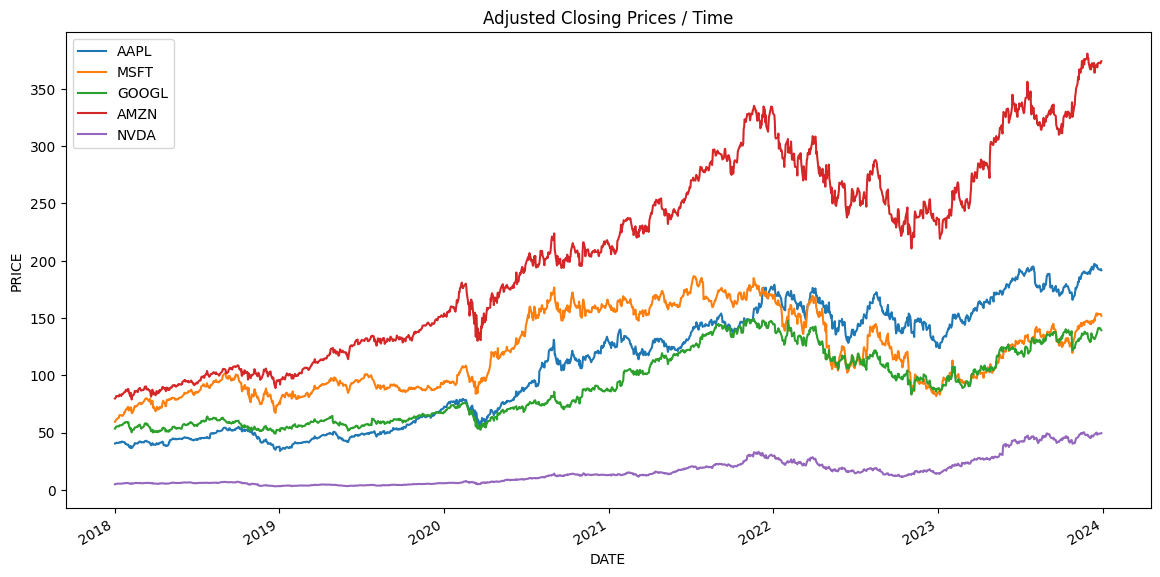

In [11]:
data['Adj Close'].plot(figsize=(14, 7), title="Adjusted Closing Prices / Time")
plt.xlabel("DATE")
plt.ylabel("PRICE")
plt.legend(stocks)
plt.show()

### Feature Engineering

In [12]:
# Calculating the percentage change to see how a stock's price has increased or decreased in value
for stock in stocks:
    # Use correct formatting
    data[('Pct Change', stock)] = data['Adj Close'][stock].pct_change()

# Calculating moving averages to see trends without short-term fluctuations 
# Calculate moving averages
for stock in stocks:
    data[('MA_5', stock)] = data['Adj Close'][stock].rolling(window=5).mean()
    data[('MA_20', stock)] = data['Adj Close'][stock].rolling(window=20).mean()
    data[('MA_50', stock)] = data['Adj Close'][stock].rolling(window=50).mean()

# Calculate volatility using the percentage change
for stock in stocks:
    # Ensure the percentage change column exists before calculating volatility
    if ('Pct Change', stock) in data.columns:
        data[('Volatility', stock)] = data[('Pct Change', stock)].rolling(window=30).std()

# Calculating the volume moving average and spikes
for stock in stocks:
    data[('Volume MA', stock)] = data['Volume'][stock].rolling(window=20).mean()
    data[('Volume Spike', stock)] = data['Volume'][stock] > (data[('Volume MA', stock)] * 1.5)  # Days with volume significantly higher than mean

# Drop any rows with NaN values resulting from the rolling calculations
data.dropna(inplace=True)

print(data.head())


#data.to_csv(csv_path)


Price                      Adj Close                                   \
Ticker                          AAPL       AMZN      GOOGL       MSFT   
Date                                                                    
2018-03-14 00:00:00+00:00  42.149345  79.550003  57.302608  87.536263   
2018-03-15 00:00:00+00:00  42.198948  79.115997  57.388393  87.844070   
2018-03-16 00:00:00+00:00  42.050140  78.584000  56.580898  88.235809   
2018-03-19 00:00:00+00:00  41.407654  77.246498  54.867638  86.640846   
2018-03-20 00:00:00+00:00  41.393471  79.325500  54.654667  86.864700   

Price                                    Close                        \
Ticker                         NVDA       AAPL       AMZN      GOOGL   
Date                                                                   
2018-03-14 00:00:00+00:00  6.155532  44.610001  79.550003  57.444500   
2018-03-15 00:00:00+00:00  6.170380  44.662498  79.115997  57.530499   
2018-03-16 00:00:00+00:00  6.198590  44.505001  78.5840

Date
2018-03-14 00:00:00+00:00    6.2185
2018-03-15 00:00:00+00:00    6.2335
2018-03-16 00:00:00+00:00    6.2620
2018-03-19 00:00:00+00:00    6.0250
2018-03-20 00:00:00+00:00    6.2395
Name: (Close, NVDA), dtype: float64
0    6.2185
1    6.2335
2    6.2620
3    6.0250
4    6.2395
Name: (Close, NVDA), dtype: float64


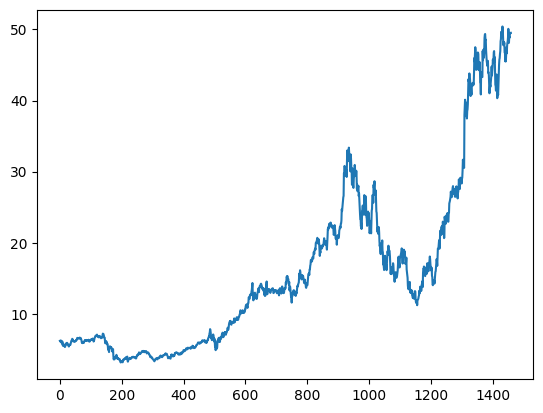

In [13]:
names = ['NVDA', 'AMZN', 'GOOGL', 'MSFT', 'AAPL']
types = ['']
print(data[('Close', 'NVDA')].head(5))
def choose_stock(name:str, type:str):
    new_data = data.reset_index()[(type, name)]
    plt.plot(new_data)
    return new_data

print(choose_stock('NVDA', 'Close').head(5))

[[1.68570305e-08]
 [3.17486254e-08]
 [2.28905141e-08]
 [3.49284663e-08]
 [2.52559020e-09]]


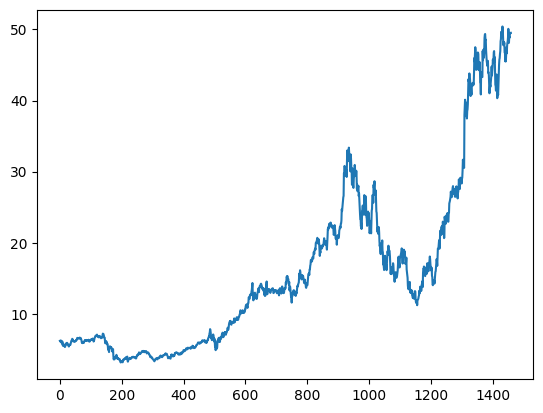

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def partition_data(data):
    train_size = int(len(data)*0.65)
    test_size = len(data) - train_size
    train_data,test_data = data[0:train_size,:],data[train_size:len(data),:1]
    return train_data,test_data

this_data = choose_stock('NVDA', 'Close')
this_data = scaler.fit_transform(np.array(data).reshape(-1,1)) 
train_data, test_data = partition_data(this_data)
print(train_data[0:5])

In [15]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [16]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

InternalError: cudaGetDevice() failed. Status: Error loading CUDA libraries. GPU will not be used.

In [ ]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)


Epoch 1/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 104s 104ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 93s 96ms/step - loss: 0.0010 - val_loss: 8.9692e-04
Epoch 3/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 91s 95ms/step - loss: 8.9310e-04 - val_loss: 8.5525e-04
Epoch 4/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 91s 95ms/step - loss: 6.7197e-04 - val_loss: 3.4609e-04
Epoch 5/100
963/963 ━━━━━━━━━━━━━━━━━━━━ 91s 94ms/step - loss: 2.5603e-04 - val_loss: 5.4507e-04
Epoch 6/100
164/963 ━━━━━━━━━━━━━━━━━━━━ 1:07 85ms/step - loss: 2.1119e-04

KeyboardInterrupt: 

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
look_back = 100
trainPredictPlot = np.empty_like(this_data)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(this_data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(this_data) - 1,:] = test_predict

plt.plot(scaler.inverse_transform(this_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Ensure the data size is divisible by 100 for reshaping
train_samples = len(X_train) - (len(X_train) % 100)  # Truncate to the closest multiple of 100 cause input size was too large before
test_samples = len(X_test) - (len(X_test) % 100) 

X_train_truncated = X_train[:train_samples]
X_test_truncated = X_test[:test_samples]

X_train_tensor = torch.tensor(X_train_truncated, dtype=torch.float32).reshape(-1, 100, 1)
X_test_tensor = torch.tensor(X_test_truncated, dtype=torch.float32).reshape(-1, 100, 1)

Y_train_tensor = torch.tensor(Y_train[:train_samples], dtype=torch.float32).reshape(-1, 1)
Y_test_tensor = torch.tensor(Y_test[:test_samples], dtype=torch.float32).reshape(-1, 1)


In [27]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, time_step):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_layer_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.fc(x[:, -1, :])  
        return x


In [28]:
input_size = 1  
hidden_layer_size = 50
model = LSTMModel(input_size, hidden_layer_size, time_step)


In [29]:
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
model = model.to(device)

# Move data to GPU
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)


Using device: cuda


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Ensure the device is CUDA (GPU) if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to GPU
model = model.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)  # Move batch to GPU
        Y_batch = Y_batch.to(device)  # Move target to GPU

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Validation loop
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)  # Move batch to GPU
        Y_batch = Y_batch.to(device)  # Move target to GPU

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        print(f"Test Loss: {loss.item()}")


Epoch 1/100, Loss: 0.00011138507397845387
Epoch 2/100, Loss: 0.00012937992869410664
Epoch 3/100, Loss: 6.497342837974429e-05
Epoch 4/100, Loss: 0.0005422604735940695
Epoch 5/100, Loss: 6.18059766566148e-06
Epoch 6/100, Loss: 8.158278069458902e-05
Epoch 7/100, Loss: 0.00022350475774146616
Epoch 8/100, Loss: 0.00022001824981998652
Epoch 9/100, Loss: 4.3052688852185383e-05
Epoch 10/100, Loss: 5.0749942602124065e-05
Epoch 11/100, Loss: 0.00023434852482751012
Epoch 12/100, Loss: 2.7612046324065886e-05
Epoch 13/100, Loss: 4.9281934479949996e-05
Epoch 14/100, Loss: 2.6692907340475358e-05
Epoch 15/100, Loss: 0.00037052982952445745
Epoch 16/100, Loss: 0.00019390643865335733
Epoch 17/100, Loss: 1.888955921458546e-05
Epoch 18/100, Loss: 3.626903890108224e-06
Epoch 19/100, Loss: 0.0001319195725955069
Epoch 20/100, Loss: 2.8251650292077102e-05
Epoch 21/100, Loss: 8.26608174975263e-06
Epoch 22/100, Loss: 2.5046849259524606e-05
Epoch 23/100, Loss: 2.8904335067636566e-06
Epoch 24/100, Loss: 1.61817424